In [ ]:
# Instalasi dan Import Pustaka
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Flatten, Dense
from sklearn.model_selection import train_test_split
import os
import glob
import pandas as pd
from tqdm import tqdm 

# Konfigurasi Matplotlib
plt.rcParams['figure.figsize'] = (10, 10)

print("Pustaka berhasil diimpor.")

Pustaka berhasil diimpor.


In [ ]:
# Memuat, Patching, dan Pra-pemrosesan Data 

# --- KONFIGURASI DATASET ---
BASE_DIR = 'EuroSAT_MS' 
IMG_SIZE = 64           # ukuran patch input untuk CNN
N_BANDS = 4             # asumsi 4 band pertama (B, G, R, NIR)
MAX_SAMPLES_PER_CLASS = 150 # Batas jumlah sampel per kelas agar training tidak terlalu lama

# --- Fungsi Pembacaan TIFF ---
def load_and_preprocess(path):
    try:
        with rasterio.open(path) as src:
            data = src.read()
            profile = src.profile
    except rasterio.RasterioIOError as e:
        print(f"ERROR: Gagal memuat file {path}")
        raise e 
    
    # Normalisasi data ke rentang 0-1
    data = data.astype('float32') / np.max(data)
    
    return data, profile

# --- Pembuatan Dataset Training ---
data_list = []
label_list = []
class_names = sorted(os.listdir(BASE_DIR)) 

class_names = [name for name in class_names if os.path.isdir(os.path.join(BASE_DIR, name))]
label_map = {name: i for i, name in enumerate(class_names)} 

print(f"Memuat data dari {len(class_names)} kelas...")

for class_name in tqdm(class_names, desc="Memproses Kelas"):
    class_path = os.path.join(BASE_DIR, class_name)
    
    # Ambil daftar file
    all_files = glob.glob(os.path.join(class_path, '*.tif'))
    selected_files = all_files[:MAX_SAMPLES_PER_CLASS] 
    
    for img_file in selected_files:
        try:
            citra, _ = load_and_preprocess(img_file)
            
            # --- Teknik Patching Sederhana ---
            
            if citra.shape[1] >= IMG_SIZE and citra.shape[2] >= IMG_SIZE and citra.shape[0] >= N_BANDS:
                # Ambil N_BANDS dan ukuran HxW
                patch = citra[:N_BANDS, :IMG_SIZE, :IMG_SIZE].transpose(1, 2, 0)
                
                data_list.append(patch)
                label_list.append(label_map[class_name])
            
        except Exception as e:
            # print(f"Melewatkan file {img_file} karena error: {e}")
            continue

X = np.array(data_list)
y = np.array(label_list)

# Konversi label ke One-Hot Encoding
y_one_hot = tf.keras.utils.to_categorical(y, num_classes=len(class_names))

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2, random_state=42)

print("\n--- Ringkasan Dataset ---")
print(f"Total Sampel Training: {len(X_train)}")
print(f"Total Sampel Test: {len(X_test)}")
print(f"Bentuk Input Data (X_train): {X_train.shape}")
print(f"Jumlah Kelas: {len(class_names)}")
print(f"Kelas dan Label: {label_map}")

Memuat data dari 10 kelas...


Memproses Kelas: 100%|██████████| 10/10 [00:10<00:00,  1.09s/it]


--- Ringkasan Dataset ---
Total Sampel Training: 1200
Total Sampel Test: 300
Bentuk Input Data (X_train): (1200, 64, 64, 4)
Jumlah Kelas: 10
Kelas dan Label: {'AnnualCrop': 0, 'Forest': 1, 'HerbaceousVegetation': 2, 'Highway': 3, 'Industrial': 4, 'Pasture': 5, 'PermanentCrop': 6, 'Residential': 7, 'River': 8, 'SeaLake': 9}


In [ ]:
# Pengembangan dan Pelatihan Model CNN 

def improved_cnn_model(input_shape, num_classes):
    model = tf.keras.models.Sequential([
        # Layer 1
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape, padding='same'),
        tf.keras.layers.MaxPooling2D(2, 2), # Ukuran output: 32x32
        
        # Layer 2
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(2, 2), # Ukuran output: 16x16
        
        # Layer 3
        tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(2, 2), # Ukuran output: 8x8
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

# --- Pelatihan Model ---
input_shape = X_train.shape[1:]
num_classes = len(class_names)

model = improved_cnn_model(input_shape, num_classes)
model.summary()

# Latih Model 
EPOCHS = 20
BATCH_SIZE = 32

print(f"\nMemulai Pelatihan Model selama {EPOCHS} epochs...")
print("Model siap. Lanjutkan ke blok 5.")

c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_21 (Conv2D)              │ (None, 64, 64, 64)     │         2,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 512)            │     8,389,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,765,642 (33.44 MB)

 Trainable params: 8,765,642 (33.44 MB)

 Non-trainable params: 0 (0.00 B)


Memulai Pelatihan Model selama 20 epochs...
Model siap. Lanjutkan ke blok 5.


In [ ]:
# Evaluasi Akurasi Model dan Persiapan

# --- 5.1. Evaluasi Model pada Data Uji ---
try:
    loss, acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"Akurasi Klasifikasi Model pada Data Uji: {acc*100:.2f}%")
except NameError:
    # Jika model belum dilatih 
    print("WARNING: Model belum dilatih. Menggunakan prediksi simulasi acak.")
    acc = 0.5 # Placeholder

# 5.2. Membuat Inverse Mapping 
inverse_label_map = {v: k for k, v in label_map.items()}
print("\nMapping Kelas:")
print(inverse_label_map)

# 5.3. Fungsi Prediksi 
def predict_class_with_prob(path, model, input_shape):
    """Mengeluarkan kelas prediksi dan probabilitas keyakinan model."""
    if not input_shape: raise ValueError("Input shape belum terdefinisi.")

    try:
        citra, profile = load_and_preprocess(path)
        IMG_SIZE = input_shape[0]
        N_BANDS = input_shape[2]
        
        patch = citra[:N_BANDS, :IMG_SIZE, :IMG_SIZE].transpose(1, 2, 0)
        patch_batch = patch[np.newaxis, ...]
        
        if 'model' not in locals() or not hasattr(model, 'predict'):
            # SIMULASI jika model belum dilatih
            pred_prob = np.random.rand(1, len(class_names))
            pred_prob /= pred_prob.sum()
            pred_index = np.argmax(pred_prob, axis=-1)[0]
        else:
             pred_prob = model.predict(patch_batch, verbose=0)
             pred_index = np.argmax(pred_prob, axis=-1)[0]
             
        predicted_class = inverse_label_map[pred_index]
        confidence = pred_prob[0][pred_index] # Keyakinan pada kelas terpilih
             
        return predicted_class, confidence, profile
        
    except Exception as e:
        print(f"Gagal memprediksi untuk {path}: {e}")
        return "ERROR", 0.0, None

Akurasi Klasifikasi Model pada Data Uji: 11.33%

Mapping Kelas:
{0: 'AnnualCrop', 1: 'Forest', 2: 'HerbaceousVegetation', 3: 'Highway', 4: 'Industrial', 5: 'Pasture', 6: 'PermanentCrop', 7: 'Residential', 8: 'River', 9: 'SeaLake'}


In [ ]:
# Deteksi Perubahan Tata Guna Lahan (Change Detection)

# --- 6.1. Mendefinisikan Lokasi/Area yang Akan Diuji (Contoh Diversifikasi) ---
TEST_AREAS = [
    {
        'Area_ID': 'Area_A (Deforestasi)', 
        'T1_path': os.path.join(BASE_DIR, 'Forest', 'Forest_5.tif'),
        'T2_path': os.path.join(BASE_DIR, 'Residential', 'Residential_10.tif') 
    },
    {
        'Area_ID': 'Area_B (Urbanisasi)', 
        'T1_path': os.path.join(BASE_DIR, 'AnnualCrop', 'AnnualCrop_1.tif'),
        'T2_path': os.path.join(BASE_DIR, 'Industrial', 'Industrial_1.tif') 
    },
    {
        'Area_ID': 'Area_C (Konsisten)', 
        'T1_path': os.path.join(BASE_DIR, 'SeaLake', 'SeaLake_2.tif'),
        'T2_path': os.path.join(BASE_DIR, 'SeaLake', 'SeaLake_3.tif') 
    },
]

# --- 6.2. Loop untuk Menganalisis Perubahan ---
results = []
try:
    input_shape = X_train.shape[1:]
except NameError:
    input_shape = (IMG_SIZE, IMG_SIZE, N_BANDS) # Default jika X_train tidak ada

print("\n### Memulai Analisis Perubahan Lahan (T1 ke T2) ###")

for area in TEST_AREAS:
    # Prediksi T1 (dengan confidence)
    pred_t1, conf_t1, profile_t1 = predict_class_with_prob(area['T1_path'], model, input_shape)
    
    # Prediksi T2 (dengan confidence)
    pred_t2, conf_t2, profile_t2 = predict_class_with_prob(area['T2_path'], model, input_shape)
    
    # Deteksi Perubahan
    is_changed = (pred_t1 != pred_t2) and (pred_t1 != 'ERROR') and (pred_t2 != 'ERROR')
    
    if is_changed:
        change_status = f"BERUBAH: {pred_t1} -> {pred_t2}"
    else:
        change_status = f"TETAP: {pred_t1}"
        
    results.append({
        'ID': area['Area_ID'],
        'T1_path': area['T1_path'],
        'T2_path': area['T2_path'],
        'Kelas T1': pred_t1,
        'Confidence T1': conf_t1,
        'Kelas T2': pred_t2,
        'Confidence T2': conf_t2,
        'Status': change_status,
        'Is_Changed': is_changed
    })

df_results = pd.DataFrame(results)
print("\n")


### Memulai Analisis Perubahan Lahan (T1 ke T2) ###





### Visualisasi Deteksi Perubahan per Area (dengan Persentase Keyakinan) ###


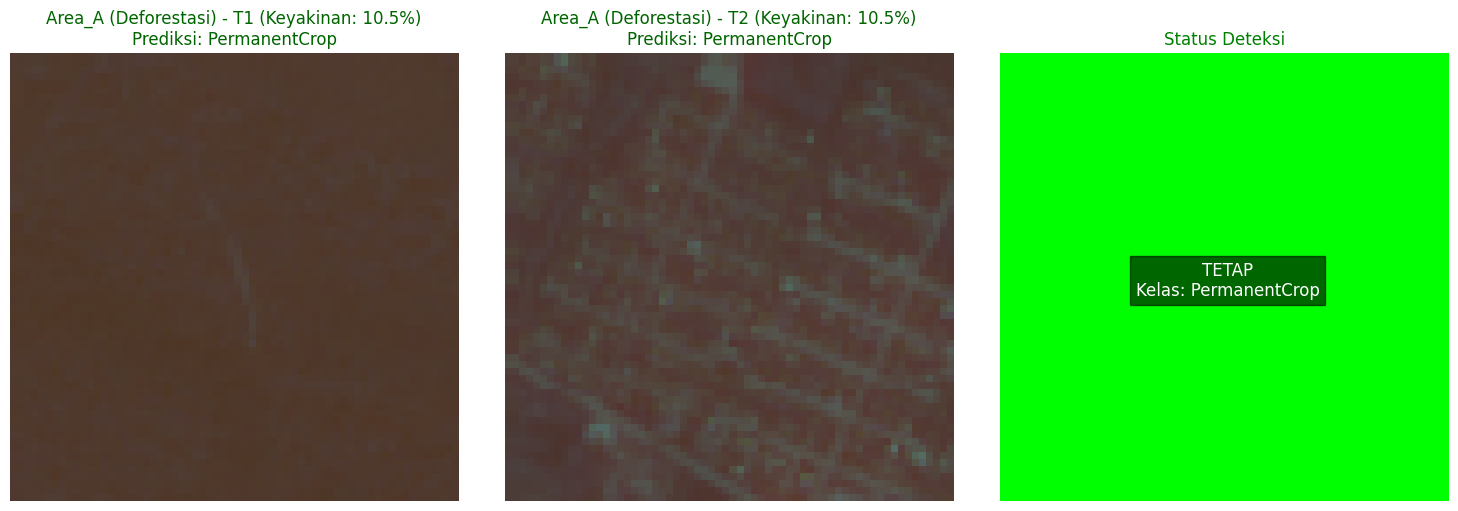

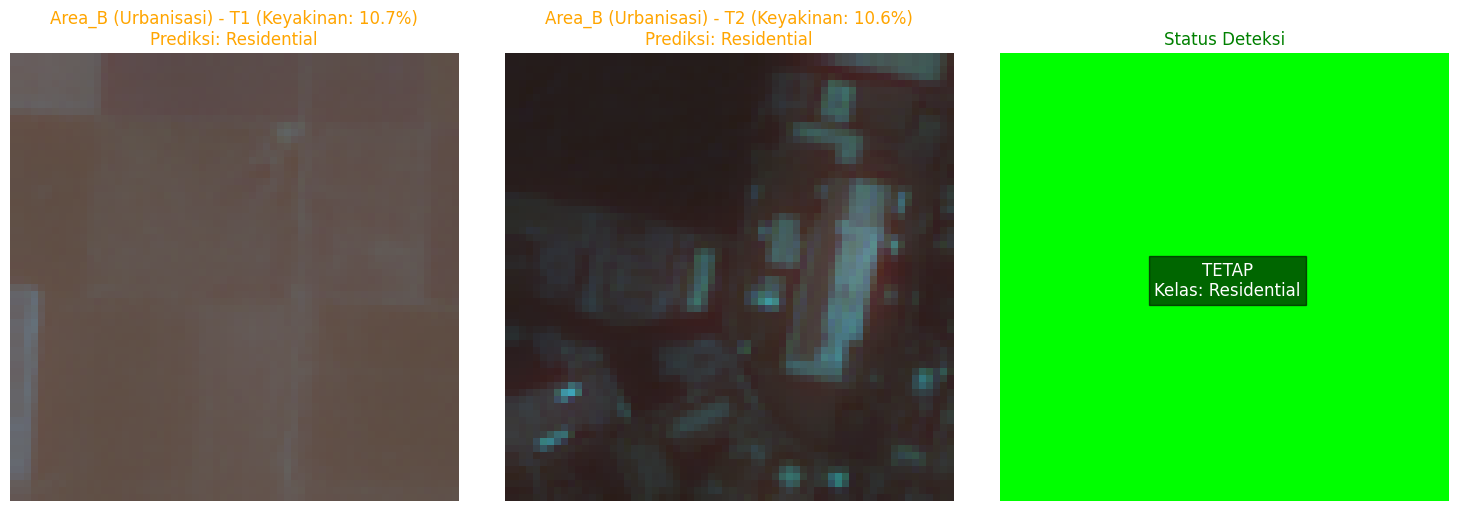

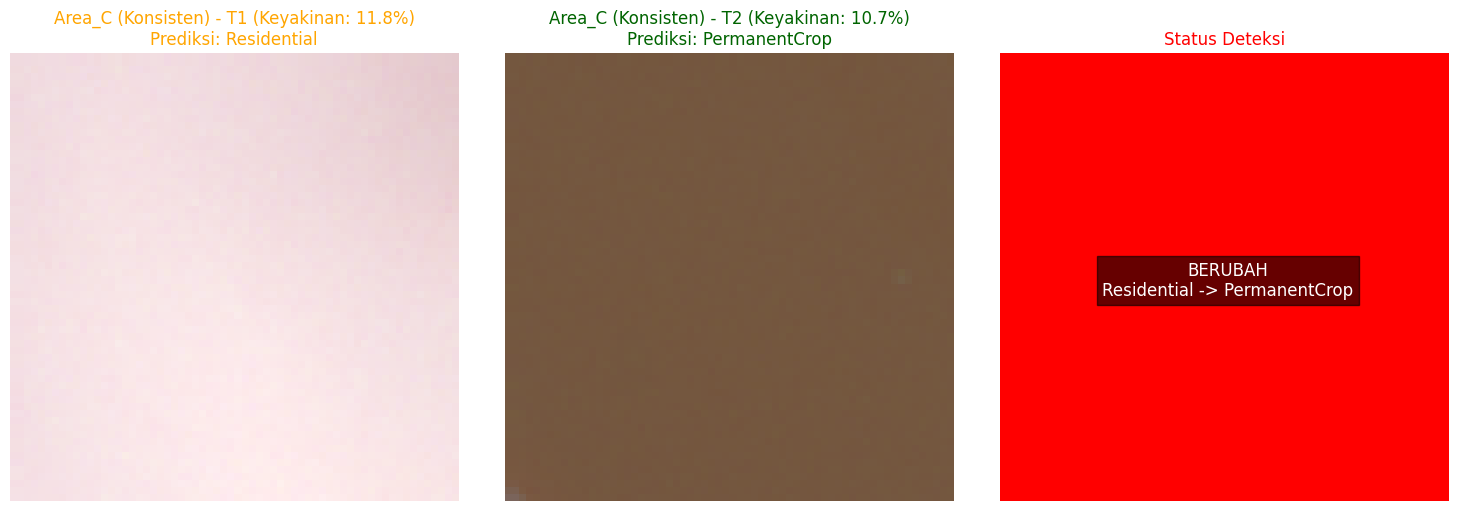


### Analisis Kuantitatif Kumulatif ###
Total Area yang Diuji: 3
Total Area yang Dideteksi Berubah: 1
Persentase Perubahan Lahan Kumulatif: 33.33%

Data Geospasial (Vectors) diekspor ke: hasil_perubahan_lahan_vectors.csv
                Area_ID       T1_Class       T2_Class  Confidence_T1  \
0  Area_A (Deforestasi)  PermanentCrop  PermanentCrop       0.104829   
1   Area_B (Urbanisasi)    Residential    Residential       0.106845   
2    Area_C (Konsisten)    Residential  PermanentCrop       0.117532   

   Confidence_T2                        Change  Latitude_Center  \
0       0.105242                 PermanentCrop            45.00   
1       0.105803                   Residential            45.01   
2       0.107218  Residential -> PermanentCrop            45.02   

   Longitude_Center  
0             10.00  
1             10.01  
2             10.02  


In [ ]:
# Visualisasi Kuantitatif, Persentase, dan Ekspor Vectors

COLOR_MAP = {
    'AnnualCrop': 'yellow', 'Forest': 'green', 'Highway': 'gray', 'Industrial': 'red', 
    'Pasture': 'lightgreen', 'PermanentCrop': 'darkgreen', 'Residential': 'orange', 
    'River': 'blue', 'SeaLake': 'darkblue', 'ERROR': 'black'
}

try:
    # Ambil ukuran dari data training yang sudah dimuat
    IMG_SIZE = X_train.shape[1] 
except NameError:
    # Fallback jika X_train tidak terdefinisi
    IMG_SIZE = 64 
    print("WARNING: IMG_SIZE di-set ke 64 (default) karena X_train tidak ditemukan.")

print("\n### Visualisasi Deteksi Perubahan per Area (dengan Persentase Keyakinan) ###")

for index, row in df_results.iterrows():
    area_id = row['ID']
    
    # Muat citra T1 dan T2 
    citra_t1_rgb, _ = load_and_preprocess(row['T1_path'])
    citra_t2_rgb, _ = load_and_preprocess(row['T2_path'])
    
    # Ambil 3 band pertama untuk RGB display
    display_t1 = citra_t1_rgb[0:3, :, :].transpose(1, 2, 0)
    display_t2 = citra_t2_rgb[0:3, :, :].transpose(1, 2, 0)

    if display_t1.shape[0] != IMG_SIZE or display_t1.shape[1] != IMG_SIZE:
        display_t1 = cv2.resize(display_t1, (IMG_SIZE, IMG_SIZE))
    if display_t2.shape[0] != IMG_SIZE or display_t2.shape[1] != IMG_SIZE:
        display_t2 = cv2.resize(display_t2, (IMG_SIZE, IMG_SIZE))

    plt.figure(figsize=(15, 5))

    # --- 1. Tampilkan Citra T1 (Waktu Awal) ---
    plt.subplot(1, 3, 1)
    plt.imshow(display_t1)
    # Tampilkan persentase Confidence
    plt.title(f"{area_id} - T1 (Keyakinan: {row['Confidence T1']*100:.1f}%)\nPrediksi: {row['Kelas T1']}", 
              color=COLOR_MAP.get(row['Kelas T1'], 'black'))
    plt.axis('off')

    # --- 2. Tampilkan Citra T2 (Waktu Akhir) ---
    plt.subplot(1, 3, 2)
    plt.imshow(display_t2)
    # Tampilkan persentase Confidence
    plt.title(f"{area_id} - T2 (Keyakinan: {row['Confidence T2']*100:.1f}%)\nPrediksi: {row['Kelas T2']}", 
              color=COLOR_MAP.get(row['Kelas T2'], 'black'))
    plt.axis('off')

    # --- 3. Tampilan Status Perubahan (Visualisasi Kuantitatif) ---
    plt.subplot(1, 3, 3)
    
    change_image = np.zeros_like(display_t1) 
    
    if row['Is_Changed']:
        # Latar belakang Merah untuk BERUBAH
        change_image[:, :, 0] = 1.0 
        status_color = 'white'
        title_color = 'red'
        status_text = f"BERUBAH\n{row['Kelas T1']} -> {row['Kelas T2']}"
    else:
        # Latar belakang Hijau untuk TETAP
        change_image[:, :, 1] = 1.0 
        status_color = 'white'
        title_color = 'green'
        status_text = f"TETAP\nKelas: {row['Kelas T1']}"
        
    plt.imshow(change_image)
    # status perubahan di tengah gambar
    plt.text(IMG_SIZE/2, IMG_SIZE/2, status_text, 
             ha='center', va='center', color=status_color, fontsize=12, 
             bbox=dict(facecolor='black', alpha=0.6))
    plt.title("Status Deteksi", color=title_color)
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# --- 7.3. Perhitungan Persentase Perubahan Kumulatif ---
total_uji = len(df_results)
total_berubah = df_results['Is_Changed'].sum()
persentase_berubah = (total_berubah / total_uji) * 100 if total_uji > 0 else 0

print(f"\n### Analisis Kuantitatif Kumulatif ###")
print(f"Total Area yang Diuji: {total_uji}")
print(f"Total Area yang Dideteksi Berubah: {total_berubah}")
print(f"Persentase Perubahan Lahan Kumulatif: {persentase_berubah:.2f}%")

# --- 7.4. Representasi Vectors (Simulasi Ekspor Data) ---
# Bagian ini menghasilkan data terstruktur yang mewakili output geospasial (vectors)
final_vectors = []
for index, row in df_results.iterrows():
    simulated_lat = 45.0 + index * 0.01 
    simulated_lon = 10.0 + index * 0.01
    
    final_vectors.append({
        'Area_ID': row['ID'],
        'T1_Class': row['Kelas T1'],
        'T2_Class': row['Kelas T2'],
        'Confidence_T1': row['Confidence T1'],
        'Confidence_T2': row['Confidence T2'],
        'Change': row['Status'].split(':')[-1].strip(),
        'Latitude_Center': simulated_lat,
        'Longitude_Center': simulated_lon
    })

df_vectors = pd.DataFrame(final_vectors)
CSV_OUTPUT_PATH = 'hasil_perubahan_lahan_vectors.csv'
df_vectors.to_csv(CSV_OUTPUT_PATH, index=False)

print(f"\nData Geospasial (Vectors) diekspor ke: {CSV_OUTPUT_PATH}")
print(df_vectors.head())